https://www.datacamp.com/tutorial/random-forests-classifier-python
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [49]:
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np
pd.set_option('display.max_columns', None)

In [50]:
original = pd.read_csv('train.csv')


In [52]:
# drop rows where tempo is missing
original = original[original['Tempo'].notna()]
# drop rows where genre speechness and valence are missing
original = original[original['Speechiness'].notna()]
original = original[original['Valence'].notna()]

In [53]:
training_Y = original['Danceability']
original.drop(['Danceability'], axis=1, inplace=True) 

In [54]:
def fillOptions(data, option = 'max'):
    if data.isna().sum() != len(data):
        if option == 'max':
            return data.value_counts().idxmax()
        elif option == 'mean':
            return data.mean()
        elif option == 'median':
            return data.median()

In [55]:
def verifyID(original, newData):
    noInNewData = original[~original['id'].isin(newData['id'])]
    return pd.concat([newData, noInNewData], ignore_index=True)   

In [56]:
def filterArtistComposerDance(data, nameColumnFill):

    listArtist = data['Artist'].unique()
    listComposer = data['Composer'].unique()
    
    filter = list(product(listArtist, listComposer))

    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        artist, composer = i[0], i[1]
        filterData = data[(data['Artist'] == artist) & (data['Composer'] == composer) ]
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)
    return newData

In [57]:
def filterArtist(data, nameColumnFill):
    listDance = data['Artist'].unique()
    filter = listDance


    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        dance = i
        filterData = data[ (data['Artist'] == dance)]
    
    
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)

    return newData

In [58]:
def filterFillData(data, nameColumnFill):
    if not data.isnull().any().any():
        return data
    else:
        for nameColumn in nameColumnFill:
            fillInfo = fillOptions(data[nameColumn], option = 'max')
            if fillInfo != None:
                data.loc[:,nameColumn].fillna(fillInfo, inplace=True)
    return data



In [59]:
def dataPreprocessing(original):
    
    pd.options.mode.chained_assignment = None

    data = original.copy()

    nameColumnFill = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Duration_ms', 'Views', 'Likes', "Stream" , "Comments"]

    # License and official_video
    data['Licensed'].fillna(data['official_video'], inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['official_video'].fillna(data['Licensed'], inplace=True)
    data['official_video'].fillna(False, inplace=True)

    data['official_video'].fillna(False, inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['Licensed'].replace({True: 1, False: 0})
    data['official_video'].replace({True: 1, False: 0})

    # Create new class = 'Unknown'
    data['Composer'].fillna("Unknown", inplace=True)
    data['Artist'].fillna("Unknown", inplace=True)
    data['Album_type'].fillna("Unknown", inplace=True)

    

    newData = filterArtistComposerDance(data, nameColumnFill)
    data = newData.copy()

    newData = filterArtist(data, nameColumnFill)
    data = newData.copy()

    newData = filterFillData(data, nameColumnFill)
    data = newData.copy()

    #Transform type key to use as class
    data['Key'] = data['Key'].astype(int)
    data['Key'] = data['Key'].astype(str)

    data = data.sort_values('id')

    # DELETE Track, Album, Uri, Url_spotify, Url_youtube, Description, Title, Channel, id, Comments
    data.drop(['Track', 'Album', 'Uri', 'Url_spotify', 'Url_youtube', 'Description', 'Title', 'Channel', 'id'], axis=1, inplace=True)

    pd.options.mode.chained_assignment = 'warn'

    return data
    


In [60]:
def convertEncoderPD(data, prefix = 'key'):
    titleKeys = []
    for i in range(data.shape[1]):
        titleKeys.append(f'{prefix}_{i}')
    
    return pd.DataFrame(data=data, columns= titleKeys)


In [61]:
def createEncodeDataTraining(data):

    encoderKey = OneHotEncoder()
    encodedKey = encoderKey.fit_transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = OneHotEncoder()
    encodedKeyAlbumType = encoderAlbumType.fit_transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = OneHotEncoder()
    encodedKeyComposer = encoderComposer.fit_transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = LabelEncoder()
    encodedArtist = encoderArtist.fit_transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = StandardScaler()
    scaledData = scaler.fit_transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return {"key": encoderKey, 'AlbumType': encoderAlbumType, 'Composer': encoderComposer, "Artist":encoderArtist} , scaler, data, scaledData_pd
    

In [62]:
def createEncodeDataTesting(encoder, scalerStandard, data):

    encoderKey = encoder['key']
    encodedKey = encoderKey.transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = encoder['AlbumType']
    encodedKeyAlbumType = encoderAlbumType.transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = encoder['Composer']
    encodedKeyComposer = encoderComposer.transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = encoder['Artist']
    encodedArtist = encoderArtist.transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = scalerStandard
    scaledData = scaler.transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return data, scaledData_pd

In [63]:
data = dataPreprocessing(original)

/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [64]:
encoders, scalerStandard, data, scaledData_pd = createEncodeDataTraining(data)

/home/zow/anaconda3/envs/fintech2/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
test = pd.read_csv('test.csv')
dataTest = dataPreprocessing(test)
testOriginal, testScaled = createEncodeDataTesting(encoders, scalerStandard, dataTest)

/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_24216/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [66]:
scaledData_pd

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Licensed,official_video,Comments,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,AlbumType_0,AlbumType_1,AlbumType_2,AlbumType_3,Composer_0,Composer_1,Composer_2,Composer_3,Composer_4,Composer_5,Composer_6,Composer_7,Composer_8,Composer_9,Composer_10,Artist
0,-1.392856,-3.787845,-0.493261,2.720431,-0.265652,-0.284171,-0.755226,-1.260104,-0.997737,-0.219622,-0.275176,-0.452269,-1.529211,-1.780398,-0.099249,-0.358290,-0.336248,-0.454824,-0.323391,5.926167,-0.273193,-0.286542,-0.267356,-0.367958,-0.270789,-0.316934,-0.417052,0.810370,-0.175151,-0.528707,-0.463273,-0.065347,-0.344887,-0.373071,-0.277759,-0.267153,-0.243855,-0.088909,-0.417988,2.404086,-0.318556,0.090075
1,0.093454,0.612871,-0.672119,-0.525968,-0.263381,-0.265464,-0.938681,-0.770945,0.369548,1.000428,0.436499,-0.473090,0.653932,0.561672,0.029525,-0.358290,-0.336248,-0.454824,-0.323391,-0.168743,3.660415,-0.286542,-0.267356,-0.367958,-0.270789,-0.316934,-0.417052,-1.234004,5.709363,-0.528707,-0.463273,-0.065347,-0.344887,-0.373071,-0.277759,3.743173,-0.243855,-0.088909,-0.417988,-0.415959,-0.318556,1.041792
2,0.460422,0.793552,-0.607613,-0.525903,-0.265999,-0.282960,1.291313,-0.602241,0.338569,-0.350116,-0.358937,0.336566,-1.529211,-1.780398,-0.112686,-0.358290,-0.336248,-0.454824,3.092228,-0.168743,-0.273193,-0.286542,-0.267356,-0.367958,-0.270789,-0.316934,-0.417052,-1.234004,-0.175151,1.891407,-0.463273,-0.065347,-0.344887,-0.373071,3.600242,-0.267153,-0.243855,-0.088909,-0.417988,-0.415959,-0.318556,0.451071
3,0.680308,0.244550,-0.521605,-0.525759,-0.265999,-0.288348,1.442153,-0.166290,0.111997,0.097415,0.094450,0.070346,0.653932,0.561672,0.085244,-0.358290,-0.336248,2.198651,-0.323391,-0.168743,-0.273193,-0.286542,-0.267356,-0.367958,-0.270789,-0.316934,-0.417052,0.810370,-0.175151,-0.528707,-0.463273,-0.065347,-0.344887,-0.373071,-0.277759,-0.267153,-0.243855,-0.088909,-0.417988,-0.415959,3.139165,-1.353911
4,0.680308,-0.221178,-0.671142,-0.172028,-0.265999,-0.244755,0.618646,-0.496395,-0.505136,-0.161432,-0.190228,-0.079341,0.653932,0.561672,-0.083478,-0.358290,-0.336248,-0.454824,-0.323391,-0.168743,-0.273193,-0.286542,-0.267356,-0.367958,3.692915,-0.316934,-0.417052,0.810370,-0.175151,-0.528707,-0.463273,-0.065347,2.899502,-0.373071,-0.277759,-0.267153,-0.243855,-0.088909,-0.417988,-0.415959,-0.318556,-0.730371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10578,-0.005129,0.121052,-0.558745,-0.525982,-0.264014,-0.256451,-1.919552,2.159853,-0.461540,-0.350094,-0.357375,-0.464684,0.653932,0.561672,-0.113328,-0.358290,-0.336248,-0.454824,-0.323391,-0.168743,-0.273193,-0.286542,-0.267356,-0.367958,3.692915,-0.316934,-0.417052,0.810370,-0.175151,-0.528707,-0.463273,-0.065347,2.899502,-0.373071,-0.277759,-0.267153,-0.243855,-0.088909,-0.417988,-0.415959,-0.318556,-0.566282
10579,1.933951,0.306734,-0.605658,-0.122886,-0.265999,-0.286083,0.541187,-1.038828,-1.215438,-0.345396,-0.358820,0.007151,0.653932,0.561672,-0.113328,-0.358290,2.973996,-0.454824,-0.323391,-0.168743,-0.273193,-0.286542,-0.267356,-0.367958,-0.270789,-0.316934,-0.417052,-1.234004,-0.175151,1.891407,-0.463273,-0.065347,-0.344887,-0.373071,-0.277759,-0.267153,-0.243855,-0.088909,-0.417988,2.404086,-0.318556,0.352617
10580,1.002504,0.668749,-0.293879,-0.268150,-0.265999,-0.259031,-0.433161,1.587599,-0.820363,-0.351027,-0.359301,-0.224424,0.653932,0.561672,-0.113328,2.791033,-0.336248,-0.454824,-0.323391,-0.168743,-0.273193,-0.286542,-0.267356,-0.367958,-0.270789,-0.316934,-0.417052,0.810370,-0.175151,-0.528707,-0.463273,-0.065347,-0.344887,-0.373071,-0.277759,-0.267153,4.100792,-0.088909,-0.417988,-0.415959,-0.318556,1.140246
10581,0.497167,-0.877807,3.168922,-0.323715,-0.265999,-0.280171,0.056051,1.151681,-1.086916,-0.351151,-0.320784,-0.509244,

In [67]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)

### RandomForestRegressor

In [68]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
import pickle

#Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# filename = "random_forest_regressor.joblib"
# pickle.dump(rf, open(filename, "wb"))

RandomForestRegressor(n_estimators=1000, random_state=42)

In [69]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
predictions = np.rint(predictions)
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.65


In [70]:
# Use the forest's predict method on the test data
predictionsTest = rf.predict(testScaled)
predictionsTest = np.rint(predictionsTest)


In [71]:
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('RandomForestRegressor.csv')

In [72]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submissionRF.csv', index=False)

In [73]:
# # load model
# loaded_model = pickle.load(open(filename, "rb"))
# # you can use loaded model to compute predictions
# predicted = loaded_model.predict(test_features)

# predicted = np.rint(predicted)
# errors = abs(predicted - test_labels)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2))

# XGBOOST

In [74]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
best_params = {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 30, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'random_state': 0}
default_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 0,
    'n_jobs': -1
}

best_model = XGBRegressor(**default_params)
best_model.fit(train_features, train_labels)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [75]:

preds = best_model.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.6969167725044494


In [76]:
best_model.feature_importances_

array([0.09104487, 0.03743535, 0.18619005, 0.09050953, 0.02137596,
       0.03084503, 0.23657869, 0.12107693, 0.02474539, 0.02297872,
       0.03892768, 0.01335248, 0.00526937, 0.00360863, 0.01471071,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01153954, 0.        , 0.        , 0.00994259,
       0.        , 0.        , 0.        , 0.        , 0.01560435,
       0.        , 0.        , 0.00987495, 0.        , 0.        ,
       0.        , 0.00699558, 0.        , 0.        , 0.        ,
       0.        , 0.00739356], dtype=float32)

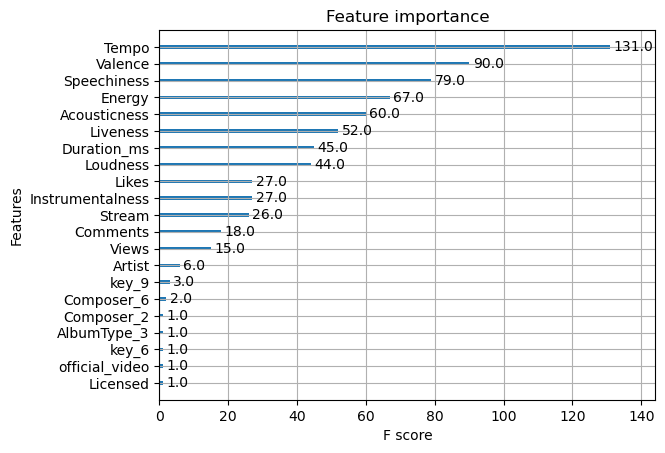

In [77]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(best_model)
pyplot.show()

In [78]:
# Use the forest's predict method on the test data
predictionsTest = best_model.predict(testScaled)
predictionsTest = np.rint(predictionsTest)
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('XGB.csv')


In [79]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# ADABOOST

In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
base_estimator = DecisionTreeRegressor(max_depth=3, splitter='best', min_samples_split=2)
model = AdaBoostRegressor(base_estimator=base_estimator,n_estimators=500, random_state=42) #n_estimators = 1000, random_state = 42
model.fit(train_features, train_labels)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=500, random_state=42)

In [81]:

preds = model.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 2.0128823251664074


# LIGHTGBM

In [82]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_features, train_labels)
lgb_eval = lgb.Dataset(test_features, test_labels, reference=lgb_train)
params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'num_leaves': 40,
              'learning_rate': 0.1,
              'feature_fraction': 0.9
              }
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train','valid'],
   )


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 8466, number of used features: 42
[LightGBM] [Info] Start training from score 4.567919
[1]	train's l2: 7.63602	valid's l2: 7.68304
[2]	train's l2: 7.03943	valid's l2: 7.15028
[3]	train's l2: 6.54738	valid's l2: 6.70194
[4]	train's l2: 6.13758	valid's l2: 6.34682
[5]	train's l2: 5.84241	valid's l2: 6.09752
[6]	train's l2: 5.53331	valid's l2: 5.83334
[7]	train's l2: 5.27678	valid's l2: 5.61103
[8]	train's l2: 5.05609	valid's l2: 5.42169
[9]	train's l2: 4.8594	valid's l2: 5.27614
[10]	train's l2: 4.68776	valid's l2: 5.12294
[11]	train's l2: 4.54066	valid's l2: 5.01255
[12]	train's l2: 4.41457	valid's l2: 4.91345
[13]	train's l2: 4.29272	valid's l2: 4.8268
[14]	train's l2: 4.19788	valid's l2: 4.76712
[15]	train's l2: 4.10035	valid's l2: 

In [83]:

preds = gbm.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.6208711532528037


In [84]:
# Use the forest's predict method on the test data
predictionsTest = gbm.predict(testScaled)
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)